Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [50]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.20,
    subset='training'
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [51]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.20,
    subset='validation'
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

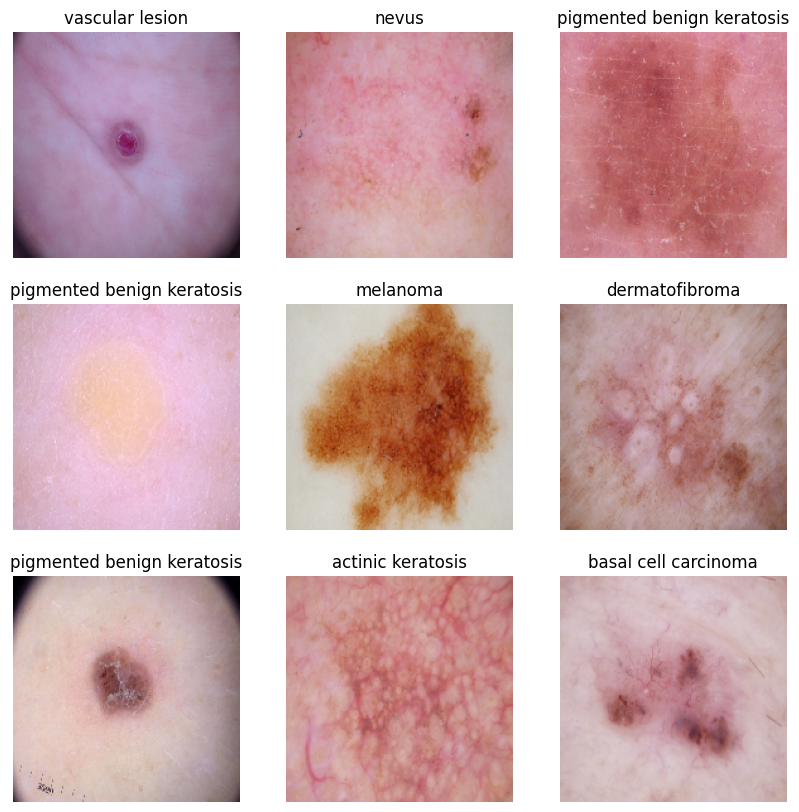

In [52]:
### your code goes here, you can use training or validation data to visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [40]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [53]:
### Your code goes here
num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(num_classes,activation='softmax')
])



### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [54]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [55]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 41, 41, 32)       

### Train the model

In [56]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 22s 333ms/step - loss: 2.0582 - accuracy: 0.2059 - val_loss: 2.0520 - val_accuracy: 0.1946
Epoch 2/20
56/56 [==============================] - 19s 302ms/step - loss: 2.0153 - accuracy: 0.2355 - val_loss: 2.0052 - val_accuracy: 0.2394
Epoch 3/20
56/56 [==============================] - 19s 302ms/step - loss: 1.9235 - accuracy: 0.3030 - val_loss: 1.8048 - val_accuracy: 0.3781
Epoch 4/20
56/56 [==============================] - 18s 286ms/step - loss: 1.8100 - accuracy: 0.3315 - val_loss: 1.7330 - val_accuracy: 0.3736
Epoch 5/20
56/56 [==============================] - 18s 289ms/step - loss: 1.6460 - accuracy: 0.4129 - val_loss: 1.5550 - val_accuracy: 0.4340
Epoch 6/20
56/56 [==============================] - 20s 318ms/step - loss: 1.5366 - accuracy: 0.4509 - val_loss: 1.4986 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 18s 286ms/step - loss: 1.5332 - accuracy: 0.4654 - val_loss: 1.4903 - val_accuracy: 0.4810

### Visualizing training results

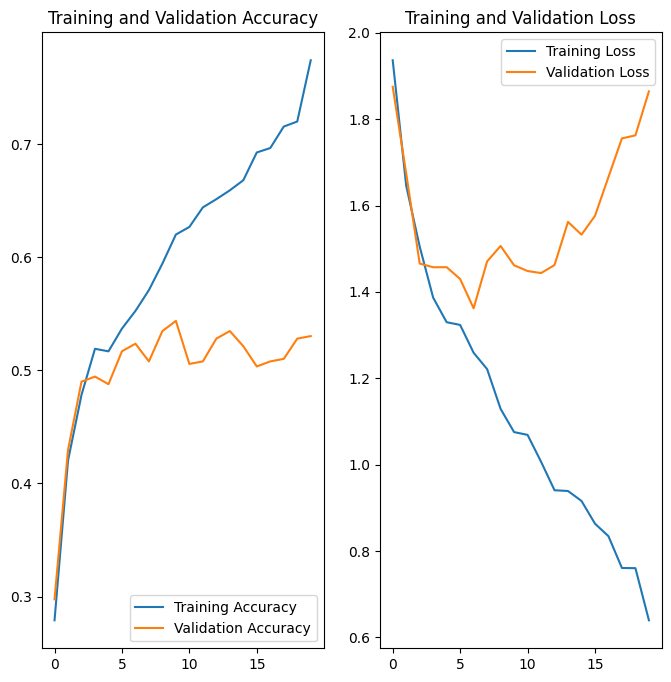

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

The accuracy of training set compare with test set is huge and because the score for training is higher than test, it is a clear sign of overfitting. To solve this issue, one strategy is to augment data. To acchive this, each image will be shearing, zooming and flipping

In [57]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

IMG_SIZE = 100

data_augmentation = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

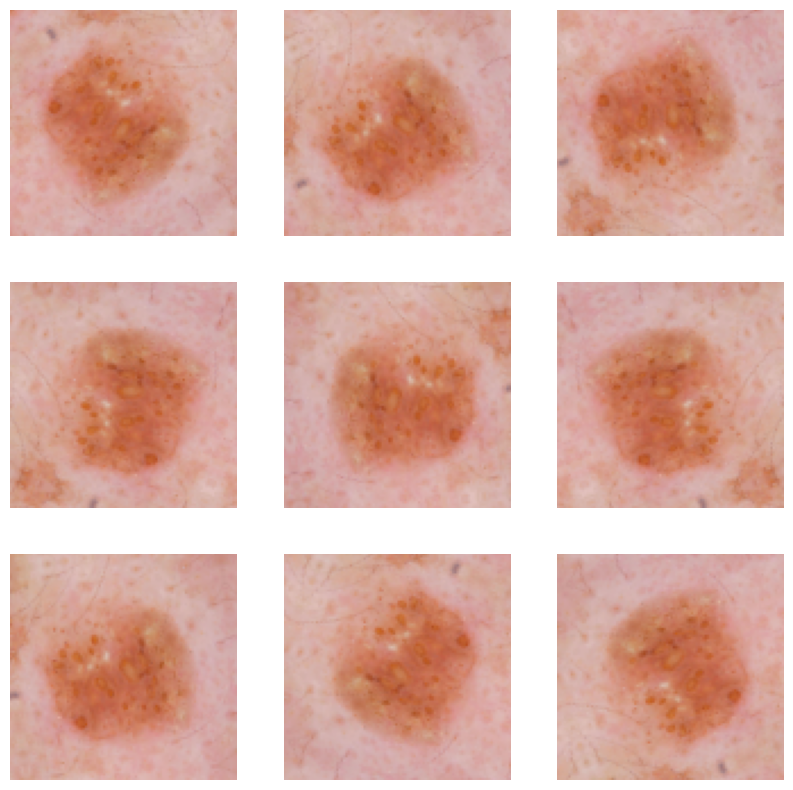

In [58]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
IMG_SIZE = 100
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  #data_augmentation,
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE,input_shape=(180,180,3)),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  # Rest of your model.
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  #tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  #tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  #tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(64, activation='relu'),
  #tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes,activation='softmax')
])

### Compiling the model

In [ ]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_6 (Resizing)       (None, 100, 100, 3)       0         
                                                                 
 random_flip_6 (RandomFlip)  (None, 100, 100, 3)       0         
                                                                 
 random_rotation_6 (RandomRo  (None, 100, 100, 3)      0         
 tation)                                                         
                                                                 
 conv2d_26 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 49, 49, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 47, 47, 32)      

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 26ms/step - loss: 6.9818 - accuracy: 0.2037 - val_loss: 1.9100 - val_accuracy: 0.2729
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.9857 - accuracy: 0.2684 - val_loss: 1.9588 - val_accuracy: 0.3177
Epoch 3/20
56/56 [==============================] - 1s 18ms/step - loss: 1.7691 - accuracy: 0.3460 - val_loss: 1.7277 - val_accuracy: 0.4116
Epoch 4/20
56/56 [==============================] - 1s 17ms/step - loss: 1.7534 - accuracy: 0.3945 - val_loss: 1.7140 - val_accuracy: 0.3870
Epoch 5/20
56/56 [==============================] - 1s 17ms/step - loss: 1.6496 - accuracy: 0.4102 - val_loss: 1.8324 - val_accuracy: 0.3378
Epoch 6/20
56/56 [==============================] - 1s 17ms/step - loss: 1.6218 - accuracy: 0.4302 - val_loss: 1.5456 - val_accuracy: 0.4810
Epoch 7/20
56/56 [==============================] - 1s 17ms/step - loss: 1.6338 - accuracy: 0.4286 - val_loss: 1.6460 - val_accuracy: 0.4228
Epoch 8/20
56

### Visualizing the results

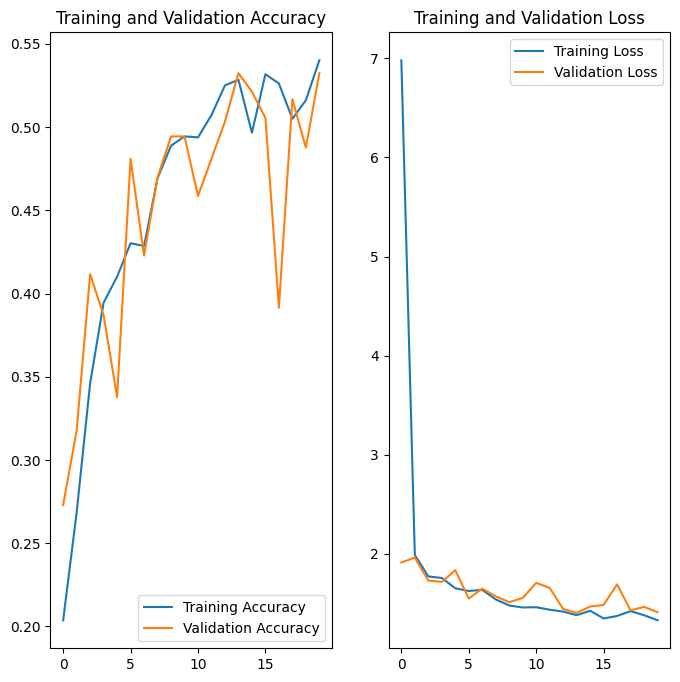

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Comparing the accuracy from training and validation, it is noticeable that they are very close this time, which means that signal of overfitting have been solve. Also the validation accuracy haven't improve compared to the previous model.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
for i in class_names:
  dir = pathlib.Path(str(data_dir_train) + '/' + i)
  print(i)
  image_count_train = len(list(dir.glob('**/*.jpg')))
  print(image_count_train)

actinic keratosis
114
basal cell carcinoma
376
dermatofibroma
95
melanoma
438
nevus
357
pigmented benign keratosis
462
seborrheic keratosis
77
squamous cell carcinoma
181
vascular lesion
139


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
dermatofibroma
#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="To do"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(pathlib.Path(str(data_dir_train) + '/' + i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8B6D7645E0>: 100%|██████████| 500/500 [00:26<00:00, 18.64 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8CA2AE40D0>: 100%|██████████| 500/500 [00:31<00:00, 15.76 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8B6D17FB20>: 100%|██████████| 500/500 [00:30<00:00, 16.38 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F8B6CF36980>: 100%|██████████| 500/500 [02:12<00:00,  3.78 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8C0C609B40>: 100%|██████████| 500/500 [01:53<00:00,  4.40 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8B6EB241F0>: 100%|██████████| 500/500 [00:29<00:00, 17.05 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F8B6CF34130>: 100%|██████████| 500/500 [01:01<00:00,  8.10 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8C0D304FD0>: 100%|██████████| 500/500 [00:27<00:00, 18.04 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8B6D527100>: 100%|██████████| 500/500 [00:29<00:00, 16.89 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028197.jpg_7c51b43e-4a58-4d5e-8dcd-8c9d1d606d69.jpg',
 '/content/gdrive/MyDrive/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031489.jpg_5dd8e20c-6e80-4553-9615-b3a20aa0de0f.jpg',
 '/content/gdrive/MyDrive/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024590.jpg_74260651-50e4-4d81-8997-24c1c60cae79.jpg',
 '/content/gdrive/MyDrive/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031614.jpg_8f0cd20d-9c4a-4807-8c5c-292fc103ebd9.jpg',
 '/content/gdrive/MyDrive/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029201.jpg_c9df15fd-8917-4652-83fc-8ddb5371b18d.jpg',
 '/content/gdrive/MyDrive/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030271.jpg_955ec14f-abbf-4b4e-8309-3943ef7f9d1b.jpg',
 '/content/gdrive/MyDrive/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_00285

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
path_list_old = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list_old

['/content/gdrive/MyDrive/Train/basal cell carcinoma/ISIC_0024550.jpg',
 '/content/gdrive/MyDrive/Train/basal cell carcinoma/ISIC_0024504.jpg',
 '/content/gdrive/MyDrive/Train/basal cell carcinoma/ISIC_0024564.jpg',
 '/content/gdrive/MyDrive/Train/basal cell carcinoma/ISIC_0024515.jpg',
 '/content/gdrive/MyDrive/Train/basal cell carcinoma/ISIC_0024572.jpg',
 '/content/gdrive/MyDrive/Train/basal cell carcinoma/ISIC_0024573.jpg',
 '/content/gdrive/MyDrive/Train/basal cell carcinoma/ISIC_0024590.jpg',
 '/content/gdrive/MyDrive/Train/basal cell carcinoma/ISIC_0024799.jpg',
 '/content/gdrive/MyDrive/Train/basal cell carcinoma/ISIC_0024949.jpg',
 '/content/gdrive/MyDrive/Train/basal cell carcinoma/ISIC_0024665.jpg',
 '/content/gdrive/MyDrive/Train/basal cell carcinoma/ISIC_0024931.jpg',
 '/content/gdrive/MyDrive/Train/basal cell carcinoma/ISIC_0024743.jpg',
 '/content/gdrive/MyDrive/Train/basal cell carcinoma/ISIC_0024582.jpg',
 '/content/gdrive/MyDrive/Train/basal cell carcinoma/ISIC_002489

In [ ]:
lesion_list_old = [i.split('/')[5] for i in path_list_old]
lesion_list_old

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [ ]:
dataframe_dict_old = dict(zip(path_list_old, lesion_list_old))
original_df = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-30-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train=pathlib.Path("/content/gdrive/MyDrive/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(num_classes,activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 32)        9

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)# your model fit code

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 2082s 12s/step - loss: 1.8528 - accuracy: 0.2832 - val_loss: 1.5415 - val_accuracy: 0.4373
Epoch 2/30
169/169 [==============================] - 39s 218ms/step - loss: 1.4561 - accuracy: 0.4603 - val_loss: 1.4503 - val_accuracy: 0.4454
Epoch 3/30
169/169 [==============================] - 36s 206ms/step - loss: 1.2896 - accuracy: 0.5252 - val_loss: 1.2519 - val_accuracy: 0.5226
Epoch 4/30
169/169 [==============================] - 34s 197ms/step - loss: 1.1655 - accuracy: 0.5708 - val_loss: 1.1667 - val_accuracy: 0.5761
Epoch 5/30
169/169 [==============================] - 34s 196ms/step - loss: 1.0290 - accuracy: 0.6241 - val_loss: 1.0843 - val_accuracy: 0.5991
Epoch 6/30
169/169 [==============================] - 36s 205ms/step - loss: 0.9332 - accuracy: 0.6575 - val_loss: 0.9181 - val_accuracy: 0.6503
Epoch 7/30
169/169 [==============================] - 34s 196ms/step - loss: 0.7705 - accuracy: 0.7209 - val_loss: 0.8680 - val_accuracy: 0.6

#### **Todo:**  Visualize the model results

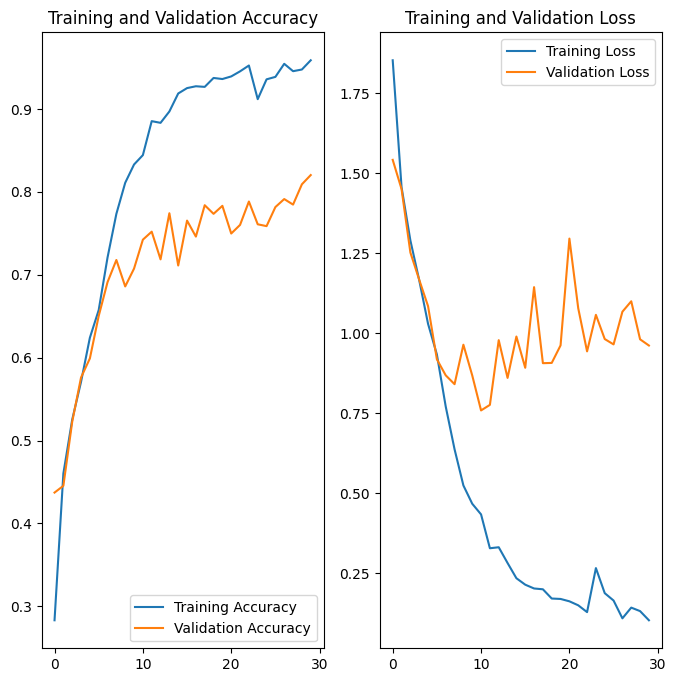

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Overfitting still is appearing due to the difference in accuracy between training and validation, but definitively is less compared to how was at the beggining. Class rebalance contributed to increase the validation accuracy, making the model a better fit reaching a good score, that shows that the imbalance that existed in the set was affecting the accuracy of the model.